<a href="https://www.kaggle.com/code/taaaan/foody-sentiment-analysis?scriptVersionId=118042041" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Readme
## What are we building?
Building a natural language processing model to handle Sentiment Analysis on Foody reviews. The data is contain files for predicting the rating on Foody based on people's reviews. We need to classify each reviews into 2 class of Rating: 1(Positive) and 0(Negative).
## Architecture
<p align="center">
    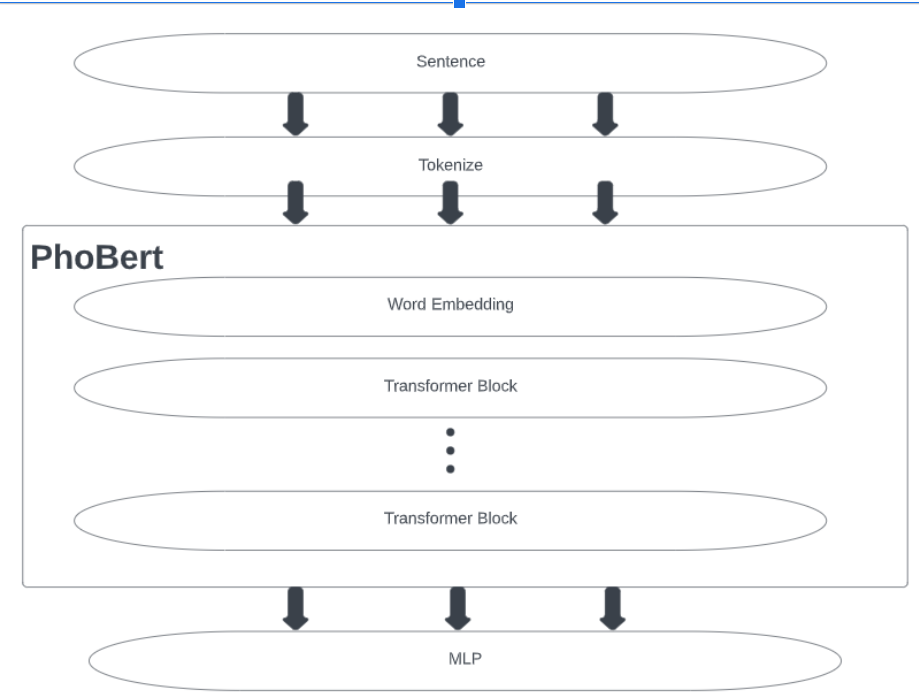
</p>

### Tokenize
- Using pretrained language models for Vietnamese: PhoBert-base. <br/>
- Phobert-base has been pre trained on 20GB of Vietnamese text <br/>
- With Phobert's tokenizer, Input is a sentence, Output is a vector of word index and a vector describes attention mask

### Phobert Prerained model
- PhoBERT pre-training approach is based on RoBERTa which optimizes the BERT pre-training procedure for more robust performance. <br/>
- It uses the same architecture of BERT-base: <br/>
- 12 layers of transformers block with a hidden size of 768 and number of self-attention heads as 12 and has around 135M trainable parameters.

### Classifier
For the classifier, we use: <br/>
- Two layers with the number of hidden units 768 <br/>
- One layer with sigmoid as activation function.

## Setup
1. Create virtual environment:<br/>
python -m venv env <br/>
2. Activate virtual environment
 - On Windows:<br/>
./env/Scripts/activate <br/>
 - On Linux:<br/>
./env/bin/activate<br/>

3. Install requirements<br/>
  pip install -r requirements.txt<br/>
4. Start Training <br/>
  Just run all cell :D Gud Luck!

------------------------------------------------------------------------------------------

# Requirements.txt
vncorenlp==1.0.3 <br/>
torch==1.11.0<br/>
pandas==1.3.5<br/>
numpy==1.21.6<br/>
seaborn==0.11.2<br/>
matplotlib==3.5.3<br/>
underthesea==1.4.0<br/>
transformers==4.20.1<br/>
scikit-learn==1.0.2<br/>
emoji==2.1.0<br/>

----------------------------------------

## Install Lib

In [1]:
!git clone https://github.com/vncorenlp/VnCoreNLP
!pip install vncorenlp
!pip install transformers
!pip install emoji
!pip install underthesea

Cloning into 'VnCoreNLP'...
remote: Enumerating objects: 236, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (24/24), done.
remote: Total 236 (delta 14), reused 1 (delta 0), pack-reused 212
Receiving objects: 100% (236/236), 214.22 MiB | 29.81 MiB/s, done.
Resolving deltas: 100% (90/90), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 25.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Created wheel for vncorenlp: filename=vncorenlp-1.0.3-py3-none-any.whl size=2645951 sha256=3696c80162f7a5b0052c33f96368a0a6179c054568a477d5191c529164ce406e
  Stored in directory: /root/.cache/pip/wheels/0c/d8/f2/d28d97379b4f6479bf51247c8dfd57fa00932fa7a74b6aab29
Successfully built vncorenlp
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 66.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 966.9/966.9 kB 34.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.7/591.7 kB 47.2 MB/s eta 0:00:00


## Import Lib

In [2]:
import re
import torch
import os
import gc
from vncorenlp import VnCoreNLP
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from underthesea import pos_tag
from underthesea import word_tokenize
from transformers import AutoTokenizer, AutoModel
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup, get_constant_schedule
from sklearn import model_selection
from sklearn.metrics import roc_auc_score, roc_curve
import codecs
import emoji
# Batch size: 16, 32
# Learning rate (Adam): 5e-5, 3e-5, 2e-5
# Number of epochs: 2, 3, 4
N_EPOCHS = 4
BATCH_SIZE = 15
LR = 1e-5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


## Load Data

In [3]:
df = pd.read_csv('/kaggle/input/sentiment-analysis-foody/full_train_1.csv', dtype = {'UserId': str})
df.drop(['image_urls', 'Unnamed: 0'], axis = 1, inplace = True)
df.dropna(inplace = True)
df.drop_duplicates(subset=['Comment'], inplace=True)
df.head()

,Comment,Rating,RevId,UserId
0,Món ăn cực tệ,0.0,0,0.0
1,Mình thấy mọi người review tích cực nhưng thực...,0.0,5,1.0
2,Chắc với sinh viên thì ai cũng quen thuộc với ...,1.0,7,2.0
3,Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì...,1.0,8,3.0
4,Không gian sạch sẽ.quán mới lên ra món hơi chậ...,1.0,12,4.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12922 entries, 0 to 13771
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Comment  12922 non-null  object 
 1   Rating   12922 non-null  float64
 2   RevId    12922 non-null  object 
 3   UserId   12922 non-null  object 
dtypes: float64(1), object(3)
memory usage: 504.8+ KB


## EDA

In [5]:
df['RevId'].nunique()

12761

In [6]:
df['Rating'].value_counts()

1.0    9635
0.0    3287
Name: Rating, dtype: int64

## Feature Engineering

### Emoj, accent handle

In [7]:
def extract_emoji(x):
  return ''.join(c for c in x if c in emoji.EMOJI_DATA)

def check_trash_emoji(str, list):
  return 1 not in [c in str for c in list]

def creat_emoji_list():
  list_emo = []
  for c in df['Comment']:
    e = extract_emoji(c)
    if len(e) > 0:
      for x in e:
        list_emo.append(x)
  list_emo = [*set(list_emo)]
  return list_emo

In [8]:
emo = creat_emoji_list()
trash_emo = []
good_emo = ['face', 'heart', 'thumb', 'finger', 'hand','cat','1st','star','up','hundred','NO']
for e in emo:
  if check_trash_emoji(emoji.demojize(e), good_emo):
    trash_emo.append(e)

# for e in emo:
#   if 'hand' in emoji.demojize(e):
#     print(e)

# for x in emo:
#   if x not in trash_emo:
#     print(x)

# print(trash_emo)
# print(len(trash_emo))
#print(emoji.demojize('👈'))

In [9]:
puncts = ['"', '-', '!', '?', '|', ';', "'", '$', '&', '/', '[', ']', '>', '%', '#', '*', '+', '\\', '•',  '~', '£', 
 '·', '_', '{', '}', '©', '^', '®', '`',  '<', '→', '°', '€', '™', '›', '←', '×', '§', '″', '′', '█', '½', '…', 
 '“', '★', '”', '–', '●', '►', '−', '¢', '²', '¬', '░', '¶', '↑', '±', '¿', '▾', '═', '¦', '║', '―', '¥', '▓', '—', '‹', '─', 
 '▒', '：', '¼', '⊕', '▼', '▪', '†', '■', '’', '▀', '¨', '▄', '♫', '☆', '¯', '♦', '¤', '▲', '¸', '¾', '⋅', '‘', '∞', 
 '∙', '↓', '、', '│', '»', '，', '♪', '╩', '╚', '³', '・', '╦', '╣', '╔', '╗', '▬', 'ï', 'Ø', '¹', '≤', '‡', '√']

puncts = puncts + emo
#print(puncts)
s1 = u'ÀÁÂÃÈÉÊÌÍÒÓÔÕÙÚÝàáâãèéêìíòóôõùúýĂăĐđĨĩŨũƠơƯưẠạẢảẤấẦầẨẩẪẫẬậẮắẰằẲẳẴẵẶặẸẹẺẻẼẽẾếỀềỂểỄễỆệỈỉỊịỌọỎỏỐốỒồỔổỖỗỘộỚớỜờỞởỠỡỢợỤụỦủỨứỪừỬửỮữỰựỲỳỴỵỶỷỸỹ'

def check_spell(string):
  # print(string)F#
  for c in string :
    if c in s1:
      return True
  return False

def clean_punct(x):
    x = str(x)
    for punct in puncts:
        if punct in x:
            x = x.replace(punct, f' {punct} ')
    return x

def clean_numbers(x):
    if bool(re.search(r'\d', x)):
        x = re.sub('[0-9]{5,}', '#####', x)
        x = re.sub('[0-9]{4}', '####', x)
        x = re.sub('[0-9]{3}', '###', x)
        x = re.sub('[0-9]{2}', '##', x)
    return x

def remove_1_length_word(x):
    list = []
    meaningful_word = ['k', 'l', 'c', 'đ', 'ú', 'ụ'] 
    for i in x:
         if len(i)> 1 or (emoji.is_emoji(i) and i not in trash_emo) or (i in meaningful_word):
            list.append(i)
    return list

In [10]:
df["check_accent"] = df["Comment"].apply(check_spell)
# check_vnese = pd.DataFrame()
# check_vnese = df[df["check_accent"] == False]
# check_vnese.to_excel('./check_vnese.xlsx')
df = df[df["check_accent"] == True]
df.drop(["check_accent"], axis = 1, inplace = True)
df.head()

,Comment,Rating,RevId,UserId
0,Món ăn cực tệ,0.0,0,0.0
1,Mình thấy mọi người review tích cực nhưng thực...,0.0,5,1.0
2,Chắc với sinh viên thì ai cũng quen thuộc với ...,1.0,7,2.0
3,Nhiều hôm thèm lẩu riêu mà chỉ có một mình thì...,1.0,8,3.0
4,Không gian sạch sẽ.quán mới lên ra món hơi chậ...,1.0,12,4.0


In [11]:

df["Comment"] = df["Comment"].apply(clean_punct)
# df["Comment"] = df["Comment"].apply(clean_numbers)
df["Comment"] = df["Comment"].apply(lambda x: [i.lower() for i in x.split(" ")])
df["Comment"] = df["Comment"].apply(lambda x: " ".join(remove_1_length_word(x)))
df.to_excel('check.xlsx')
df


,Comment,Rating,RevId,UserId
0,món ăn cực tệ,0.0,0,0.0
1,mình thấy mọi người review tích cực nhưng thực...,0.0,5,1.0
2,chắc với sinh viên thì ai cũng quen thuộc với ...,1.0,7,2.0
3,nhiều hôm thèm lẩu riêu mà chỉ có một mình thì...,1.0,8,3.0
4,không gian sạch sẽ.quán mới lên ra món hơi chậ...,1.0,12,4.0
...,...,...,...,...
13766,tính ra bánh khá đắt so với bánh mì truyền thố...,1.0,9428,9428.0
13767,"mình gọi chè thái caramen, bạn mình gọi...",1.0,9508,9508.0
13768,nghe đồn nem tai bà hồng nổi lắm thì phải \nch...,1.0,9531,9531.0
13770,lẩu ếch rất ngon. gọi nồi lẩu ếch to nước ngon...,1.0,9562,9562.0


### Stopwords

In [12]:
def create_stopwordlist():
    f = codecs.open('/kaggle/input/sentiment-analysis-foody/vietnamese-stopwords.txt', encoding='utf-8')
    data = []
    for i, line in enumerate(f):
        line = repr(line)
        line = line[1:len(line)-3]
        data.append(line)
    return data

stopword_vn = create_stopwordlist()
#stopword_vn

In [13]:
def remove_stopwords(x):
  results = []
  tmp = x.split(' ')
  for stop_word in stopword_vn:
    if stop_word in tmp:
      tmp.remove(stop_word)
  results.append(" ".join(tmp))

  s = ''
  s = s.join(results)  
  return s

In [14]:
df["Comment"] = df["Comment"].apply(remove_stopwords)

## Split data 

In [15]:
train_df, val_df = model_selection.train_test_split(df, test_size=0.1, random_state=42, stratify=df['Rating'])
del df
gc.collect()
train_df.reset_index(inplace=True)
val_df.reset_index(inplace=True)

In [16]:
# pos_df = train_df[train_df['Rating'] == 1.0]
# neg_df = train_df[train_df['Rating'] == 0.0]
# # shuffle pos_df, neg_df
# pos_df = pos_df.sample(frac=1).reset_index(drop=True)
# neg_df = neg_df.sample(frac=1).reset_index(drop=True)
# rate = len(neg_df) / len(train_df)
# number_of_neg_each_batch = int(BATCH_SIZE * rate) + 1
# number_of_pos_each_batch = BATCH_SIZE - number_of_neg_each_batch
# df = pd.DataFrame()
# j = 0
# count = 0
# for i in range(0, len(pos_df), number_of_pos_each_batch):
#     total_len = 0
#     df = pd.concat([df, pos_df[i:min(i+number_of_pos_each_batch, len(pos_df))]])
#     if j!=len(neg_df):
#         df = pd.concat([df, neg_df[j:min(len(neg_df),j+number_of_neg_each_batch)]])
#     total_len += len(neg_df[j:min(len(neg_df),j+number_of_neg_each_batch)])
#     count += total_len
#     j = min(j + number_of_neg_each_batch, len(neg_df))
# df.reset_index(drop=True, inplace=True)

## Install phobert

### Install

In [17]:
# py_vncorenlp.download_model(save_dir='/kaggle/working/')
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
rdrsegmenter = VnCoreNLP('/kaggle/working/VnCoreNLP/VnCoreNLP-1.1.1.jar', annotators="wseg", max_heap_size = '-Xmx500m')

Downloading:   0%|          | 0.00/557 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/874k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


## Dataset Architecture

In [18]:
class SentimentDataset(Dataset):
  def __init__(self, data_df: pd.DataFrame(), max_len = 256, transform=None):
    df = data_df
    self.n_samples = df.shape[0]
    self.X = df['Comment']
    self.Y = df['Rating']
    self.Id = df['RevId']
  def __getitem__(self, index):
    sample = self.X[index], self.Y[index], self.Id[index]
    return sample
  def __len__(self):
    return self.n_samples

In [19]:
prior = {
      1: ['A', 'Ab', 'I'],
      2: ['C', 'Cc', 'R'],
      3: ['L', 'M'],
      4: ['V', 'Vb', 'Vy'],
      5: ['X'],
      6: ['N', 'Nb', 'Nc', 'Ne'],
      7: ['Z'],
      8: ['E'],
      9: ['Fw', 'FW'],
      10: ['Ni', 'Np', 'NNp', 'Ns', 'Nu', 'Ny', 'P', 'S', 'T'],
      11: ['CH'],
    }
def truncate_word(text: str):
    # print(text)
    lst_words = text.split(' ')
    # print(len(lst_words))
    lst_index = []
    for i, word in enumerate(lst_words):
      if len(word) == 1:
        continue
      if word == 'emojiiiii' or word == 'sentimenttttt':
        lst_index.append((i, 0))
        continue
      # print(pos_tag(word))
      tag = pos_tag(word)[0][1]
      # print(word, tag)
      for key in prior:
        if tag in prior[key]:
          lst_index.append((i, key))
          break
    lst_index.sort(key=lambda x: x[1])
    lst_index = lst_index[:256]
    lst_index.sort(key=lambda x: x[0])
    truncated_str = ''
    for index in lst_index:
      # print(index[0])
      truncated_str += lst_words[index[0]] + ' '
    # print(truncated_str)
    return truncated_str[:-1]
    


In [20]:
super_pos_emoj = ['🤑','💯','🥰','🤩','💓','❤','💚','💗','💘','♥','💖','💙','💕','😍','💜','🧡','😘','💝','😂','😝',]
pos_emoji = ['🙃','😄','👐','😁','👌','🤤','🤭','😛','😱','😋','☝','😎','🤪','😮','😹','😊','😲','😽','😇','👏','💁','😀','🖐','😸','🙋','🤗','❣','👋','😻','😆','💛','😬','🙌','🤙','😙',
'🥵','👍','😉','😗','✋','🤞','✌','😚','🥳','🍮','🤲','🖤','🙀','😃','😜','🙅','🤓','💞','😿','⭐','🥇','☺']
neutral_emoji = ['🌞','😪','🧁','🍵','😵','🧐', '👉','🐮','🐷','😨','🔺','👈','🤝','👫','😅','🤔','🤨','🌟','👆','🔯','🌚','😳','🙄','😴','😶']
neg_emoji = ['😌','😢','😭','😕', '😯','🖕','🤦','🤥','😖','🙂','🥴','😥','😑','😷','🌝','🤧','😞','😔','😫','💔','😟','😧','😏','😠','🙏','👎','🙁','😩','😰','🥺','☹','😤','🥶','😦','😓','🤡','😣','😐']
super_neg_emoj = ['😒','🤢','🤮','🤬','😡',]
map_sentiment_w = {
    ':(': "tệ",
    ':)': "ngon",
    ':v': "ngon",
    '@@': "tệ"
}

def texts_to_features(lst_text: list):
  cleaned_lst_text = []
  for text in lst_text:
    # print(text)
    # get all emoji
    lst_emoji = re.findall(r'[\U00010000-\U0010ffff]', text)
    lst_opinion = []
    for emoj in lst_emoji:
      if emoj in super_pos_emoj:
        lst_opinion.append('rất ngon')
      elif emoj in pos_emoji:
        lst_opinion.append('ngon')
      elif emoj in neg_emoji:
        lst_opinion.append('tệ')
      elif emoj in super_neg_emoj:
        lst_opinion.append('rất tệ')
      else:
        lst_opinion.append('bình thường')
    # print(lst_emoji)
    # get all sentiment word like :))) :(( :v :(((
    lst_sentiment = re.findall(r'[:;=xX8B][-oO]?[)D\]\(\[pP/\\]', text)
    # print(lst_sentiment)
    # replace emoj by 'emojiiiii'
    text = re.sub(r'[\U00010000-\U0010ffff]', 'emojiiiii ', text)
    # replace sentiment word with 'sentimenttttt'
    text = re.sub(r'[:;=xX8B][-oO]?[)D\]\(\[pP/\\]', 'sentimenttttt ', text)
    # print(text)
    sentences = rdrsegmenter.tokenize(text)
    output = []
    for sen in sentences:
        output.append(' '.join(sen))
#     print(output)
    cleaned_text = ''
    for s in output:
        tmp = re.sub(r'[^\w\s]', ' ', s)
        cleaned_text += ' ' + tmp
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
    # print(cleaned_text)
    if(len(cleaned_text.split(' ')) > 256):
      cleaned_text = truncate_word(cleaned_text)
    # replace 'sentimenttttt' with coresponding sentiment word
    for i in range(len(lst_sentiment)):
        cleaned_text = cleaned_text.replace('sentimenttttt', lst_sentiment[i], 1)
    # replace 'emojiiiii' with coresponding emoji
    for i in range(len(lst_emoji)):
        cleaned_text = cleaned_text.replace('emojiiiii', lst_opinion[i], 1)
    # print(cleaned_text)
    # print('------------------------')
    cleaned_lst_text.append(cleaned_text)

  tmp_dict = tokenizer(cleaned_lst_text, padding=True, truncation=True, max_length=256)
  return torch.tensor(tmp_dict['input_ids']), torch.tensor(tmp_dict['attention_mask'])



## Model

In [21]:
class Sentiment_Analysis(nn.Module):
  def __init__(self):
    super(Sentiment_Analysis, self).__init__()
    self.bert = AutoModel.from_pretrained("vinai/phobert-base")
    self.linear = nn.Linear(in_features=768, out_features = 768)
    self.relu = nn.ReLU()
    self.drop = nn.Dropout(0.1)
    self.norm = nn.LayerNorm(768)
    self.linear1 = nn.Linear(in_features=768, out_features = 768)
    self.drop1 = nn.Dropout(0.075)
    self.norm1 = nn.LayerNorm(768)
    self.linear2 = nn.Linear(in_features=768, out_features = 1)
    self.sigmoid = nn.Sigmoid()
#     self.tanh = nn.Tanh()
    # self.init_weights()
    # nn.init.xavier_uniform_(self.linear.weight)
    # nn.init.xavier_uniform_(self.linear1.weight)
    # nn.init.xavier_uniform_(self.linear2.weight)
  def forward(self, input_ids, attention_mask):
    X = self.bert(input_ids=input_ids,attention_mask=attention_mask)
    X = X[1]
    X = self.linear(X)
    X = self.relu(X)
    X = self.drop(X)
    X = self.norm(X)
    X = self.linear1(X)
    X = self.relu(X)
    X = self.drop1(X)
    X = self.norm1(X)
    X = self.linear2(X)
    X = self.sigmoid(X)
    return X

## Train&Eval

### Epoch Handle

In [22]:
def train_epoch(model, criterion, optimizer, train_loader):
  model.train()
  total_loss = 0
  total = 0
  step = 1
  for data in train_loader:
    comment, label, _ = data
    # print(label.size(0), label.size(), label.tolist())
    # break
    input_ids, attention_mask = texts_to_features(comment)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    label = label.type(torch.FloatTensor).to(device)
    optimizer.zero_grad()
    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    # print("output")
    # print(outputs)
    loss = criterion(outputs.view(-1), label)
    total_loss += loss.item()
    total += label.size(0)
    loss.backward()
    optimizer.step()
    scheduler.step()
    if step < 10 or step % 100 == 0:      
      print(f"""Total loss: {total_loss:.4f} | Total: {total} | Loss: {total_loss/step:.4f}""")
    step += 1
    del input_ids
    del attention_mask
    del label
    del loss
    gc.collect()
    torch.cuda.empty_cache()

    # break
  # print(type(losses), losses)
  print(f"""Total loss: {total_loss:.4f} | Total: {total} | Loss: {total_loss/step:.4f}""")
def inference_epoch(model, criterion, data_loader, for_submit = False):
  model.eval()
  total_loss = 0
  total = 0
  y_pred = []
  y_test = []
  RevIds = []
  step = 1
  for data in data_loader:
    comment = None
    label = None
    RevId = None
    if for_submit == True:
      comment, label, RevId = data
      RevIds.extend(RevId.tolist())
    else: 
      comment, label, _ = data
    input_ids, attention_mask = texts_to_features(comment)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    label = label.type(torch.FloatTensor).to(device)
    with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)
      y_pred.extend(outputs.view(-1).tolist()) 
      y_test.extend(label.tolist())
      loss = criterion(outputs.view(-1), label)
      total_loss += loss.item()
      total += label.size(0)
    if step < 10 or step % 100 == 0:      
      print(f"""Total loss: {total_loss:.4f} | Total: {total} | Loss: {total_loss/step:.4f}""")
    step += 1
    del input_ids
    del attention_mask
    del label
    gc.collect()
    torch.cuda.empty_cache()
  if for_submit:
    return RevIds, y_pred
  print(len(y_test), len(y_pred))
  print(y_test, y_pred)
  print('AUC: ', roc_auc_score(y_test, y_pred))
  tpr, fpr, thresholds = roc_curve(y_test, y_pred)
  plt.plot(tpr, fpr)
  plt.show()


### Let go bruhhh

In [23]:
# DataLoader

train_dataset = SentimentDataset(data_df = train_df)
train_loader = DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, shuffle = True)
# train_iter = iter(train_loader)

val_dataset = SentimentDataset(data_df = val_df)
val_loader = DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, shuffle = True)
# val_iter = iter(val_loader)

#Initialize
model = Sentiment_Analysis()
model.cuda()
criterion = nn.BCELoss()
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=LR, correct_bias=False)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=100, num_training_steps=int(N_EPOCHS*len(train_loader))) 
# for i in range(n_epochs):
#   print(f'======== Epoch {i} / {n_epochs} ========')
#   print('Training...')
#   train_epoch(model, optimizer, train_loader)


Downloading:   0%|          | 0.00/518M [00:00<?, ?B/s]

Some weights of the model checkpoint at vinai/phobert-base were not used when initializing RobertaModel: ['lm_head.layer_norm.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` 

======== Epoch 1 / 4 ========
Training...
Total loss: 0.6957 | Total: 15 | Loss: 0.6957
Total loss: 1.2173 | Total: 30 | Loss: 0.6086
Total loss: 1.9950 | Total: 45 | Loss: 0.6650
Total loss: 2.5715 | Total: 60 | Loss: 0.6429
Total loss: 3.1718 | Total: 75 | Loss: 0.6344
Total loss: 3.7327 | Total: 90 | Loss: 0.6221
Total loss: 4.3441 | Total: 105 | Loss: 0.6206
Total loss: 4.8419 | Total: 120 | Loss: 0.6052
Total loss: 5.5566 | Total: 135 | Loss: 0.6174
Total loss: 37.3993 | Total: 1500 | Loss: 0.3740
Total loss: 68.8088 | Total: 3000 | Loss: 0.3440
Total loss: 95.3325 | Total: 4500 | Loss: 0.3178
Total loss: 122.7872 | Total: 6000 | Loss: 0.3070
Total loss: 154.3630 | Total: 7500 | Loss: 0.3087
Total loss: 181.7976 | Total: 9000 | Loss: 0.3030
Total loss: 206.6457 | Total: 10500 | Loss: 0.2952
Total loss: 224.6485 | Total: 11526 | Loss: 0.2918
Total loss: 0.1085 | Total: 15 | Loss: 0.1085
Total loss: 0.4040 | Total: 30 | Loss: 0.2020
Total loss: 0.4831 | Total: 45 | Loss: 0.1610
Tota

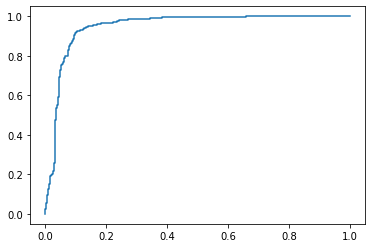

======== Epoch 2 / 4 ========
Training...
Total loss: 0.0800 | Total: 15 | Loss: 0.0800
Total loss: 0.2087 | Total: 30 | Loss: 0.1044
Total loss: 0.4779 | Total: 45 | Loss: 0.1593
Total loss: 0.5099 | Total: 60 | Loss: 0.1275
Total loss: 0.5908 | Total: 75 | Loss: 0.1182
Total loss: 0.8464 | Total: 90 | Loss: 0.1411
Total loss: 1.4544 | Total: 105 | Loss: 0.2078
Total loss: 1.5421 | Total: 120 | Loss: 0.1928
Total loss: 2.0732 | Total: 135 | Loss: 0.2304
Total loss: 22.0971 | Total: 1500 | Loss: 0.2210
Total loss: 42.8215 | Total: 3000 | Loss: 0.2141
Total loss: 66.2816 | Total: 4500 | Loss: 0.2209
Total loss: 88.4929 | Total: 6000 | Loss: 0.2212
Total loss: 109.3744 | Total: 7500 | Loss: 0.2187
Total loss: 127.9496 | Total: 9000 | Loss: 0.2132
Total loss: 150.3403 | Total: 10500 | Loss: 0.2148
Total loss: 163.4370 | Total: 11526 | Loss: 0.2123
Total loss: 0.1621 | Total: 15 | Loss: 0.1621
Total loss: 0.2974 | Total: 30 | Loss: 0.1487
Total loss: 0.5901 | Total: 45 | Loss: 0.1967
Total

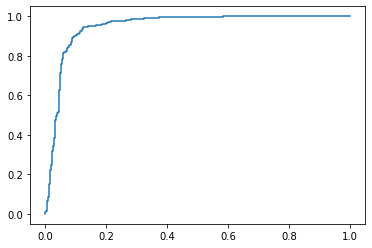

======== Epoch 3 / 4 ========
Training...
Total loss: 0.0674 | Total: 15 | Loss: 0.0674
Total loss: 0.3791 | Total: 30 | Loss: 0.1896
Total loss: 0.4635 | Total: 45 | Loss: 0.1545
Total loss: 0.6378 | Total: 60 | Loss: 0.1594
Total loss: 0.7372 | Total: 75 | Loss: 0.1474
Total loss: 0.9330 | Total: 90 | Loss: 0.1555
Total loss: 1.0390 | Total: 105 | Loss: 0.1484
Total loss: 1.2525 | Total: 120 | Loss: 0.1566
Total loss: 1.6869 | Total: 135 | Loss: 0.1874
Total loss: 20.0412 | Total: 1500 | Loss: 0.2004
Total loss: 36.2094 | Total: 3000 | Loss: 0.1810
Total loss: 55.2728 | Total: 4500 | Loss: 0.1842
Total loss: 75.4147 | Total: 6000 | Loss: 0.1885
Total loss: 95.1312 | Total: 7500 | Loss: 0.1903
Total loss: 112.5194 | Total: 9000 | Loss: 0.1875
Total loss: 131.7391 | Total: 10500 | Loss: 0.1882
Total loss: 145.3008 | Total: 11526 | Loss: 0.1887
Total loss: 0.0403 | Total: 15 | Loss: 0.0403
Total loss: 0.0817 | Total: 30 | Loss: 0.0408
Total loss: 0.2618 | Total: 45 | Loss: 0.0873
Total 

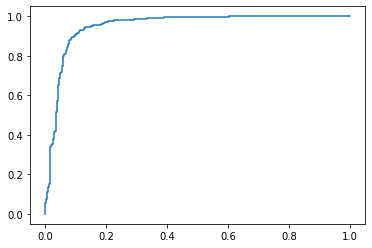

======== Epoch 4 / 4 ========
Training...
Total loss: 0.0697 | Total: 15 | Loss: 0.0697
Total loss: 0.3446 | Total: 30 | Loss: 0.1723
Total loss: 0.6541 | Total: 45 | Loss: 0.2180
Total loss: 0.7351 | Total: 60 | Loss: 0.1838
Total loss: 1.0172 | Total: 75 | Loss: 0.2034
Total loss: 1.4221 | Total: 90 | Loss: 0.2370
Total loss: 1.9142 | Total: 105 | Loss: 0.2735
Total loss: 1.9660 | Total: 120 | Loss: 0.2458
Total loss: 2.2472 | Total: 135 | Loss: 0.2497
Total loss: 18.3515 | Total: 1500 | Loss: 0.1835
Total loss: 33.8543 | Total: 3000 | Loss: 0.1693
Total loss: 50.9321 | Total: 4500 | Loss: 0.1698
Total loss: 66.7354 | Total: 6000 | Loss: 0.1668
Total loss: 84.8422 | Total: 7500 | Loss: 0.1697
Total loss: 102.4663 | Total: 9000 | Loss: 0.1708
Total loss: 119.4887 | Total: 10500 | Loss: 0.1707
Total loss: 132.5895 | Total: 11526 | Loss: 0.1722
Total loss: 0.1243 | Total: 15 | Loss: 0.1243
Total loss: 0.1402 | Total: 30 | Loss: 0.0701
Total loss: 0.4858 | Total: 45 | Loss: 0.1619
Total 

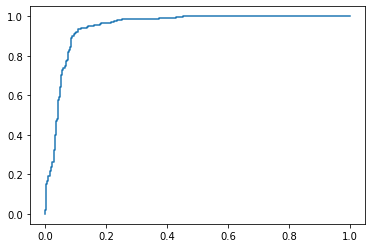

In [24]:
for i in range(N_EPOCHS):
  print(f'======== Epoch {i+1} / {N_EPOCHS} ========')
  print('Training...')
  if i == 1:
    scheduler = get_constant_schedule(optimizer)
  train_epoch(model, criterion, optimizer, train_loader)
  inference_epoch(model, criterion, val_loader)
  # break


In [25]:
# !pip list


## Submission

In [26]:
test_df = pd.read_csv('/kaggle/input/sentiment-analysis-foody/test_translated.csv')
test_df.drop(['Unnamed: 0'], axis = 1, inplace = True)
test_df.fillna('', inplace = True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5103 entries, 0 to 5102
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   RevId       5103 non-null   int64 
 1   UserId      5103 non-null   int64 
 2   Comment     5103 non-null   object
 3   image_urls  5103 non-null   object
 4   Comment2    5103 non-null   object
dtypes: int64(2), object(3)
memory usage: 199.5+ KB


In [27]:
test_df["Comment"] = test_df["Comment"].apply(clean_punct)
# df["Comment"] = df["Comment"].apply(clean_numbers)
test_df["Comment"] = test_df["Comment"].apply(lambda x: [i.lower() for i in x.split(" ")])
test_df["Comment"] = test_df["Comment"].apply(lambda x: " ".join(remove_1_length_word(x)))
test_df["Comment"] = test_df["Comment"].apply(remove_stopwords)
test_df['Rating'] = 0
test_df.head()


,RevId,UserId,Comment,image_urls,Comment2,Rating
0,781115,1326532,trà táo 35k\ncookie socola 38k \nnước bình thư...,['https://images.foody.vn/res/g8/73091/s800/fo...,,0
1,1219481,422306,hôm trung tâm tổ chức noel party mua được vouc...,['https://images.foody.vn/res/g1/33/s800/foody...,,0
2,1703765,9779143,thịt gà quán nhất đấy. đi ăn gọi liền món chân...,['https://images.foody.vn/res/g66/659655/s800/...,,0
3,4870346,12924388,hai đứa ăn xong đau bụng ngày\nchân gà ok nhưn...,['https://images.foody.vn/res/g78/772244/s800/...,,0
4,2638711,1134279,vừa thử trưa nay. điểm cộng đầu tiên bát bún đ...,['https://images.foody.vn/res/g74/737874/s800/...,,0


In [28]:
test_dataset = SentimentDataset(data_df = test_df)
test_loader = DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, shuffle = True)

In [29]:
RevIds, y_pred = inference_epoch(model, criterion, test_loader, for_submit = True)

Total loss: 3.3910 | Total: 15 | Loss: 3.3910
Total loss: 6.4378 | Total: 30 | Loss: 3.2189
Total loss: 10.3818 | Total: 45 | Loss: 3.4606
Total loss: 13.2204 | Total: 60 | Loss: 3.3051
Total loss: 17.3550 | Total: 75 | Loss: 3.4710
Total loss: 21.6104 | Total: 90 | Loss: 3.6017
Total loss: 24.7526 | Total: 105 | Loss: 3.5361
Total loss: 28.4507 | Total: 120 | Loss: 3.5563
Total loss: 32.2818 | Total: 135 | Loss: 3.5869
Total loss: 348.8937 | Total: 1500 | Loss: 3.4889
Total loss: 689.5817 | Total: 3000 | Loss: 3.4479
Total loss: 1033.2834 | Total: 4500 | Loss: 3.4443


In [30]:
submit = pd.DataFrame(columns=['RevId', 'Rating'])
submit['RevId'] = RevIds
submit['Rating'] = y_pred
submit

,RevId,Rating
0,3209189,0.990807
1,7095942,0.002229
2,1320309,0.991410
3,520066,0.990868
4,2180240,0.974524
...,...,...
5098,3776878,0.003808
5099,2646875,0.039487
5100,2915925,0.001607
5101,897910,0.987733


In [31]:
# submit.to_csv('/content.gdrive/MyDrive/Sentiment_Analysis/submission.csv', index = False)